The project Will identify the 5 states that mare the safest agricultural investment, considering hazards and climate change.
The data used in this project can be found at these locations:
- https://hazards.fema.gov/nri/data-resources
- https://projects.propublica.org/climate-migration/

Phase 1: Data Cleaning
- Import data
- Limit Columns Selected
- Add year column (This was done for a larger follow up project)
- Add Identifier Column
- Remove Null values
- Only Select 48 Contiguous States
?- Create data set grouped by states

Phase 2: Data Exploration
- Remove states based on hazards
- Genereate columns used with identifying safest investments

Phase 3: State Identification
- Weight columns and sort rows based on result
- Identify top 5 states to investigate further

Phase 4: (Follow up project) Further explore top 5 states
- A large portion of the data cleaning for this project was done to simplify Phase 4: (Follow up project)

In [1]:
import pandas as pd
import glob

path = "C:/Users/14805/Desktop/Data Projects/FRI/RI-tables/"
files = glob.glob(path + '/*.csv')

#For this code, I want to generate a dataframe for each file in the home fodler.
#Each dataframe named NRI_'year' will automatically be cleaned and added to the visuals when this code file is run. (Phase 4)

data = {}

for f in files:
    d = pd.read_csv(f)
    key_name = f.replace('_Table_Counties', '').replace('.csv', '').replace('_Chng','')
    key_name = key_name.replace('C:/Users/14805/Desktop/Data Projects/FRI/RI-tables\\', '')
    data[key_name] = d
    
print(data.keys())
print('\n')
for key in data:
    print(key, ':', data[key].shape)

dict_keys(['Expected_2050', 'NRI_2020', 'NRI_2021', 'NRI_2023'])


Expected_2050 : (3108, 8)
NRI_2020 : (3142, 350)
NRI_2021 : (3142, 365)
NRI_2023 : (3231, 465)


Above is a list of all the different dataframes in the newly created dictionary. The Expected_2050 dataframe was pulled from a propublica article, and lists expectations for the level of change a given county will likely experience by the year 2050.

We can see that the column and row count changes significantly in 2023. This change is from FEMA including more united states territories in the risk index than previous years. Calculating the NRI for each county is a fairly new process for FEMA, so each year will contain some updates. For this analysis the goal will be tracking the changes in major risks, and I will be focused on only the contiguous states.

In [2]:
#This is where I add a year column to better organize the data (Phase 4)

for key in data:
    data[key]['YEAR'] = key
    data[key]['YEAR'] = data[key]['YEAR'].str.replace('NRI_', '').str.replace('Expected_', '')
    data[key]['YEAR'] = data[key]['YEAR'].astype(int)

Next I will need to remove the columns that I will not be using for my analysis. Since I am interested in the change to risks over time, I will only need three columns from FEMA for each risk I am interested in. I will keep the 'RISKR' column because that is the rating assigned by FEMA, and will be used to identify the top 5 states in Phase 3.

For Phase 4 I will keep the annualized frequency to better compare year to year. I will also keep the risk score column as well. To calculate the risk score, and as a result their risk rating, FEMA utilizes the following formulas.

Risk Index Score = Expected Annual Loss × Social Vulnerability ÷ Community Resilience

Expected Annual Loss = Exposure × Annualized Frequency × Historical Loss Ratio

(Phase 4) To track changes to hazards over time I will need to use the annualized frequency column, as the other columns can be swayed by preparations due to awareness of a hazard, which will minimize the exposure.

In [3]:
#This is where I create a new dictionary with only the FEMA NRI datasets.

import re

nri_select = []

for key in data:
    nri_select.append(key)
    
print('nri_select :',nri_select)

wanted = []
nri_expression = '(NRI_20)\d*'

for title in nri_select:
    if re.search(nri_expression, title):
        wanted.append(title)

nri_county = {k: data[k] for k in data.keys() & set(wanted)}

print('\n')
print(nri_county.keys())

nri_select : ['Expected_2050', 'NRI_2020', 'NRI_2021', 'NRI_2023']


dict_keys(['NRI_2020', 'NRI_2023', 'NRI_2021'])


In [4]:
#The RISKR column will be used on this project, the RISKS and AFREQ columns will be utilized in Phase 4

keepers = ['NRI_ID', 'STATE', 'STATEABBRV', 'COUNTY', 'COUNTYTYPE', 'AGRIVALUE', 'AREA', 'RISK_SCORE', 'RISK_RATNG', 'CFLD_AFREQ', 'CFLD_RISKS', 'CFLD_RISKR',
           'CWAV_AFREQ', 'CWAV_RISKS', 'CWAV_RISKR', 'DRGT_AFREQ', 'DRGT_RISKS', 'DRGT_RISKR', 'HWAV_AFREQ', 'HWAV_RISKS',
           'HWAV_RISKR', 'HRCN_AFREQ', 'HRCN_RISKS', 'HRCN_RISKR', 'ISTM_AFREQ', 'ISTM_RISKS', 'ISTM_RISKR', 'RFLD_AFREQ',
           'RFLD_RISKS', 'RFLD_RISKR', 'TRND_AFREQ', 'TRND_RISKS', 'TRND_RISKR', 'WFIR_AFREQ', 'WFIR_RISKS', 'WFIR_RISKR',
           'WNTW_AFREQ', 'WNTW_RISKS', 'WNTW_RISKR', 'YEAR']

for key in nri_county:
    nri_county[key] = nri_county[key].loc[:, keepers]
    
for key in nri_county:
    print(key, ':', nri_county[key].shape)

NRI_2020 : (3142, 40)
NRI_2023 : (3231, 40)
NRI_2021 : (3142, 40)


The new data frames have the number of columns that I am looking for. Now I need to ensure that the continental United States are the only locatinos selected in the dataframes. First I'm going to create a unique identifier for each line by creating a column that combines the year and the NRI_ID, this way I can easily ensure that countys, states, and years will not accidentally duplicate down the line.

In [5]:
#This identifier will be most important on Phase 4, but was useful with identifying duplicates data when merging dataframes

def zfil(string):
    return str(string).zfill(2)

for key in nri_county:
    nri_county[key]['IDENTIFIER'] = nri_county[key]['NRI_ID'] + '_' + nri_county[key]['YEAR'].apply(zfil)
    
for key in nri_county:
    print(key, ':', nri_county[key]['IDENTIFIER'].info)

NRI_2020 : <bound method Series.info of 0       C21115_2020
1       C21117_2020
2       C21119_2020
3       C21121_2020
4       C21123_2020
           ...     
3137    C56037_2020
3138    C56039_2020
3139    C56041_2020
3140    C56043_2020
3141    C56045_2020
Name: IDENTIFIER, Length: 3142, dtype: object>
NRI_2023 : <bound method Series.info of 0       C01001_2023
1       C01003_2023
2       C01005_2023
3       C01007_2023
4       C01009_2023
           ...     
3226    C72151_2023
3227    C72153_2023
3228    C78010_2023
3229    C78020_2023
3230    C78030_2023
Name: IDENTIFIER, Length: 3231, dtype: object>
NRI_2021 : <bound method Series.info of 0       C21115_2021
1       C21117_2021
2       C21119_2021
3       C21121_2021
4       C21123_2021
           ...     
3137    C56037_2021
3138    C56039_2021
3139    C56041_2021
3140    C56043_2021
3141    C56045_2021
Name: IDENTIFIER, Length: 3142, dtype: object>


In [6]:
#This is to identify the list of states in the data set

states_full = nri_county['NRI_2020']['STATE'].unique()
print(states_full)
print('\n')
print(len(states_full))

['Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'Indiana' 'Iowa' 'New Mexico' 'New York'
 'Kansas' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'North Carolina' 'North Dakota' 'Ohio'
 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


51


In [7]:
#These are the states I will be using in my analysis

states = ['Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
 'New Hampshire', 'New Jersey', 'Indiana', 'Iowa', 'New Mexico', 'New York',
 'Kansas', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
 'Connecticut', 'Delaware', 'Florida', 'Georgia',
 'Idaho', 'Illinois', 'North Carolina', 'North Dakota', 'Ohio',
 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

print(len(states))

48


In [8]:
#The NRI dataframes now only contain the columns I want, and the Contiguous United States

for key in nri_county:
    nri_county[key] = nri_county[key][nri_county[key]['STATE'].isin(states)]
    
for key in nri_county:
    print(key, ':', nri_county[key].shape)

NRI_2020 : (3107, 41)
NRI_2023 : (3107, 41)
NRI_2021 : (3107, 41)


The last thing I will need to do before merging the datasets (Phase 4) is check on the missing variable for each of the columns, and then decide how I want to fill in the Nan variables.

We can see that even in the original data set there are some missing variables. This is because some locations do not deal with certain disaster types, or are so infrequent they are difficult to measure. FEMA simply doesn't add any data for the missing disaster types. For my analysis replacing the missing data types with a 0 will be sufficient.

In [9]:
#Checking to see if there all null values in my data

for key in nri_county:
    print(key, ':', nri_county[key].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 0 to 3141
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NRI_ID      3107 non-null   object 
 1   STATE       3107 non-null   object 
 2   STATEABBRV  3107 non-null   object 
 3   COUNTY      3107 non-null   object 
 4   COUNTYTYPE  3107 non-null   object 
 5   AGRIVALUE   3107 non-null   float64
 6   AREA        3107 non-null   float64
 7   RISK_SCORE  3107 non-null   float64
 8   RISK_RATNG  3107 non-null   object 
 9   CFLD_AFREQ  464 non-null    float64
 10  CFLD_RISKS  464 non-null    float64
 11  CFLD_RISKR  3107 non-null   object 
 12  CWAV_AFREQ  3107 non-null   float64
 13  CWAV_RISKS  3107 non-null   float64
 14  CWAV_RISKR  3107 non-null   object 
 15  DRGT_AFREQ  3107 non-null   float64
 16  DRGT_RISKS  3107 non-null   float64
 17  DRGT_RISKR  3107 non-null   object 
 18  HWAV_AFREQ  3107 non-null   float64
 19  HWAV_RISKS  3107 non-null  

In [10]:
#Correct all null values by replacing with 0

for key in nri_county:
    nri_county[key] = nri_county[key].fillna(0)
    
for key in nri_county:
    print(key, ':', nri_county[key].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 0 to 3141
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NRI_ID      3107 non-null   object 
 1   STATE       3107 non-null   object 
 2   STATEABBRV  3107 non-null   object 
 3   COUNTY      3107 non-null   object 
 4   COUNTYTYPE  3107 non-null   object 
 5   AGRIVALUE   3107 non-null   float64
 6   AREA        3107 non-null   float64
 7   RISK_SCORE  3107 non-null   float64
 8   RISK_RATNG  3107 non-null   object 
 9   CFLD_AFREQ  3107 non-null   float64
 10  CFLD_RISKS  3107 non-null   float64
 11  CFLD_RISKR  3107 non-null   object 
 12  CWAV_AFREQ  3107 non-null   float64
 13  CWAV_RISKS  3107 non-null   float64
 14  CWAV_RISKR  3107 non-null   object 
 15  DRGT_AFREQ  3107 non-null   float64
 16  DRGT_RISKS  3107 non-null   float64
 17  DRGT_RISKR  3107 non-null   object 
 18  HWAV_AFREQ  3107 non-null   float64
 19  HWAV_RISKS  3107 non-null  

My FEMA data is now all uniform, and will automitically incorporate new tables I add to the original folder, as long as they are named correctly. Each data set now has the same state counts and columns count, unique identifiers, no missing values, and year columns. The rest of this project will focus strictly on Phase 3.

The dataset 'Expected_2050' was published in 2020, and because it is a predictive dataset, it is important that it is compared with a dataset from that same year, as it is going to line up best with the data used to make the prediction regarding the expected change. The data recorded later will be used to identify if the trend predicted is playing out (Phase 4).

In [11]:
#Examining the Expected_2050 data for the first time, we can see that the county column is not only the county name.
#To avoid duplciates, I will need to leave in the county type: ex - St.Louis City and St.Louis County

print(data['Expected_2050'].head())

print(data['Expected_2050'].info())

            State                 County  Heat  Wet Bulb  Farm crop Yields  \
0  South Carolina    Beaufort County, SC     6         9                 8   
1         Arizona       Pinal County, AZ    10         6                 8   
2       Louisiana  St. Martin Parish, LA     7        10                 8   
3  South Carolina    Colleton County, SC     6         9                 8   
4         Florida     Wakulla County, FL     7         9                 8   

   Sea Level Rise  Very Large Fires  Economic Damages  YEAR  
0               7                 3                 9  2050  
1               1                 6                 7  2050  
2               4                 3                 7  2050  
3               6                 3                 8  2050  
4               4                 1                 9  2050  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  --

In [12]:
#The Expected_2050 dataset has several typos in the County and State columns
#The dataset needed several suffixes removed from the county column, it had a state mispelled, and, a county in the wrong state.

Expected_2050 = data['Expected_2050'].copy()

Expected_2050['County'] = Expected_2050['County'].str.replace(', \w+', '', regex=True)
Expected_2050['State'] = Expected_2050['State'].str.replace('Deleware', 'Delaware')
Expected_2050.loc[Expected_2050['County'] == 'Kalamazoo County', 'State'] = 'Michigan'

Expected_2050.head()

,State,County,Heat,Wet Bulb,Farm crop Yields,Sea Level Rise,Very Large Fires,Economic Damages,YEAR
0,South Carolina,Beaufort County,6,9,8,7,3,9,2050
1,Arizona,Pinal County,10,6,8,1,6,7,2050
2,Louisiana,St. Martin Parish,7,10,8,4,3,7,2050
3,South Carolina,Colleton County,6,9,8,6,3,8,2050
4,Florida,Wakulla County,7,9,8,4,1,9,2050


In [13]:
#To simplify the results on this project, I will be removing columns not needed for Phase 3
keepers = ['STATE','COUNTY', 'COUNTYTYPE', 'AGRIVALUE', 'AREA', 'CFLD_RISKR', 'CWAV_RISKR', 'DRGT_RISKR',
           'HWAV_RISKR', 'HRCN_RISKR', 'ISTM_RISKR', 'RFLD_RISKR', 'TRND_RISKR', 'WFIR_RISKR', 'WNTW_RISKR', 'YEAR']

predictive_nri = nri_county['NRI_2020'].copy()
predictive_nri = predictive_nri.loc[:, keepers]
    
print(predictive_nri.shape)

(3107, 16)


In [14]:
#Here I will generate a unique identifier in each data frame, to simplify merging, and identify missing/duplicate data.
#I will also remove unnecessary columns from the Expected_2050 Dataset

predictive_nri['STATE_COUNTY'] = predictive_nri['STATE'] + ', ' + predictive_nri['COUNTY'] + ' ' + predictive_nri['COUNTYTYPE']
predictive_nri['STATE_COUNTY'] = predictive_nri['STATE_COUNTY'].str.lower()

Expected_2050['State_county'] = Expected_2050['State'] + ', ' + Expected_2050['County']
Expected_2050['State_county'] = Expected_2050['State_county'].str.lower()
Agrivalue_2050 = Expected_2050[['State_county', 'Farm crop Yields']]

print(predictive_nri['STATE_COUNTY'].head(), predictive_nri.info())
print('\n')
print(Agrivalue_2050['State_county'].head(), Agrivalue_2050.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 0 to 3141
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STATE         3107 non-null   object 
 1   COUNTY        3107 non-null   object 
 2   COUNTYTYPE    3107 non-null   object 
 3   AGRIVALUE     3107 non-null   float64
 4   AREA          3107 non-null   float64
 5   CFLD_RISKR    3107 non-null   object 
 6   CWAV_RISKR    3107 non-null   object 
 7   DRGT_RISKR    3107 non-null   object 
 8   HWAV_RISKR    3107 non-null   object 
 9   HRCN_RISKR    3107 non-null   object 
 10  ISTM_RISKR    3107 non-null   object 
 11  RFLD_RISKR    3107 non-null   object 
 12  TRND_RISKR    3107 non-null   object 
 13  WFIR_RISKR    3107 non-null   object 
 14  WNTW_RISKR    3107 non-null   object 
 15  YEAR          3107 non-null   int32  
 16  STATE_COUNTY  3107 non-null   object 
dtypes: float64(2), int32(1), object(14)
memory usage: 424.8+ KB
0    kentuc

In [15]:
#All rows merged properly, and the extra row for Washnigton DC was removed. This is the expected result.

Agrivalue_2050 = Agrivalue_2050.merge(predictive_nri, how='right', left_on=('State_county'), right_on=('STATE_COUNTY'))
Agrivalue_2050.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 0 to 3106
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State_county      3107 non-null   object 
 1   Farm crop Yields  3107 non-null   int64  
 2   STATE             3107 non-null   object 
 3   COUNTY            3107 non-null   object 
 4   COUNTYTYPE        3107 non-null   object 
 5   AGRIVALUE         3107 non-null   float64
 6   AREA              3107 non-null   float64
 7   CFLD_RISKR        3107 non-null   object 
 8   CWAV_RISKR        3107 non-null   object 
 9   DRGT_RISKR        3107 non-null   object 
 10  HWAV_RISKR        3107 non-null   object 
 11  HRCN_RISKR        3107 non-null   object 
 12  ISTM_RISKR        3107 non-null   object 
 13  RFLD_RISKR        3107 non-null   object 
 14  TRND_RISKR        3107 non-null   object 
 15  WFIR_RISKR        3107 non-null   object 
 16  WNTW_RISKR        3107 non-null   object 


In [16]:
#This identifies our Agricultural value per sqml, which is a better indicator of small farm investment than the total Agrivalue
Agrivalue_2050['Agrivalue_SQML'] = Agrivalue_2050['AGRIVALUE']/Agrivalue_2050['AREA']

#This is making the assumption that each integer increase in the expectation that agricultural value will be negatively impacted
#will result in a 1/10 decline in agricultural production in 2050 from what was produced in 2020
#RENAME VARIABLE
Agrivalue_2050['Farm_Yield_probability'] = Agrivalue_2050['Farm crop Yields']/10

#This is the calculated future value of each county square mile, assuming the loss per expectation, in 2020 dollars.
Agrivalue_2050['Expected_Value'] = Agrivalue_2050['Agrivalue_SQML']*(1-Agrivalue_2050['Farm_Yield_probability'])

Agrivalue_2050.head()

,State_county,Farm crop Yields,STATE,COUNTY,COUNTYTYPE,AGRIVALUE,AREA,CFLD_RISKR,CWAV_RISKR,DRGT_RISKR,...,ISTM_RISKR,RFLD_RISKR,TRND_RISKR,WFIR_RISKR,WNTW_RISKR,YEAR,STATE_COUNTY,Agrivalue_SQML,Farm_Yield_probability,Expected_Value
0,"kentucky, johnson county",4,Kentucky,Johnson,County,706000.0,261.958144,Not Applicable,Relatively Low,Very Low,...,Very Low,Relatively Moderate,Relatively Low,Relatively Moderate,Relatively Low,2020,"kentucky, johnson county",2695.087048,0.4,1617.052229
1,"kentucky, kenton county",5,Kentucky,Kenton,County,5390000.0,160.213975,Not Applicable,Relatively Low,Very Low,...,Relatively Moderate,Relatively Low,Relatively High,No Rating,Relatively Moderate,2020,"kentucky, kenton county",33642.508462,0.5,16821.254231
2,"kentucky, knott county",1,Kentucky,Knott,County,408000.0,351.517978,Not Applicable,Relatively Low,Very Low,...,Very Low,Relatively Low,Relatively Low,Relatively Moderate,Relatively Low,2020,"kentucky, knott county",1160.680323,0.1,1044.612291
3,"kentucky, knox county",3,Kentucky,Knox,County,2534000.0,386.298435,Not Applicable,Relatively Moderate,Very Low,...,Relatively Low,Relatively High,Relatively Moderate,Relatively Moderate,Relatively Moderate,2020,"kentucky, knox county",6559.695223,0.3,4591.786656
4,"kentucky, larue county",4,Kentucky,Larue,County,41112000.0,261.539564,Not Applicable,Relatively Low,Relatively Low,...,Very Low,Very Low,Relatively Low,Very Low,Very Low,2020,"kentucky, larue county",157192.278865,0.4,94315.367319


Tracking down a hard number on the occurence rate of a given hazard is difficult. The National Risk Index that FEMA provides has an annualized frequency, which is caluculated using a number of variables. This annualized frequency is also used to generate that counties Risk Score, which is then sorted and grouped in the Risk Rating columnn for each hazard.

FEMA's thought process on how these variables are created can be found here:
https://hazards.fema.gov/nri/understanding-scores-ratings

Many of these variables used to calculate the risk scores are not something I have access to. As a result, I will need to trust FEMA's analysis that the RISKR column acturately represents the risk a county faces from a given hazard. This column will be used to remove counties that are a greater risk to producing agricultural goods.

For each of the following categories the following ratings are available:

'No Rating', 'Very Low', 'Relatively Low', 'Relatively Moderate', 'Relatively High', 'Very High'


CFLD_RISKR
- For coastal flooding the level of risk we will tolerate to be consdiered a safe investment will be: Relatively Low
- I want to ensure that the expected sea level rise, which will increase floodings, will not impact the surrounding infrastructure.



CWAV_RISKR
- For cold waves the level of risk we will tolerate to be considered a safe investment will be: Relatively Moderate
- Cold waves have a sever impact on crops, in particular livestock and trees, but are common accross the states.



DRGT_RISKR
- For drought the level of risk we will tolerate to be considered a safe investment will be: Relatively Moderate
- Drought conditions can change and can often be offset if a viable water source is nearby.



HWAV_RISKR
- For heat waves the level of risk we will tolerate to be considered a safe investment will be: Relatively Moderate
- Heat waves are not as damaging to crops as cold waves are, but do still pose a risk to livestock.



HRCN_RISKR
- For hurricanes the level of risk we will tolerate to be considered a safe investment will be: Relatively Moderate
- Hurricane and the storms they blow in can be quite severe in nature, however they also bring rainfall.



ISTM_RISKR
- For ice storms the level of risk we will tolerate to be considered a safe investment will be: Relatively Moderate
- This receives the same rating as cold waves, because these could cause sever damage.



RFLD_RISKR
- For rivine flooding the level of risk we will tolerate to be considered a safe investment will be: Relatively High
- Because rivine flooding can often be offset by choosing the correct location, only counties with a severe risk will be removed.



TRND_RISKR
- For tornadoes the level of risk we will tolerate to be considered a safe investment will be: Relatively High
- Tornados can cause severe damage to property, and for this reason any counties with a relatively high risk will be avoided.



WFIR_RISKR
- For wildfires the level of risk we will tolerate to be considered a safe investment will be: Relatively High
- Steps can be taken to mitigate the damage from wildfires, however locations with too high of a risk will be removed.



WNTW_RISKR
- For winter weather the level of risk we will tolerate to be considered a safe investment will be: Relatively High
- This category incldues snow, and the winter cannot be escaped. Locations with sever winter weather will be avoided.

In [17]:
#I will create a new dataframe which contains the number of counties in each state, and will then be compared to the number of
#counties in each state that pass through the filters. I will then look at the average expectation for Expected_value to
#which states are the top candidates and will warrant further investigation before investing in an agricultural business.

State_area = pd.DataFrame(Agrivalue_2050['AREA'].groupby(by=Agrivalue_2050['STATE']).sum().reset_index())
State_avg_value = pd.DataFrame(Agrivalue_2050['Expected_Value'].groupby(by=Agrivalue_2050['STATE']).mean().reset_index())

#Before removing any of the variables, I will Identify the counties with the highest expected agricultural value.

Agrivalue_2050['Expected_Value'].describe()

#These are the summary statistics for the expected future agricultural value per squaremile, the 'Expected_Value column'
#I Will use the average value to remove the lower quality candidates.

count    3.107000e+03
mean     8.687850e+04
std      1.267475e+05
min      0.000000e+00
25%      1.000943e+04
50%      3.588364e+04
75%      1.124147e+05
max      1.325284e+06
Name: Expected_Value, dtype: float64

In [18]:
#This is where I will identify the counties with low risks to agricultural production

moderate = ['No Rating', 'Very Low', 'Relatively Low', 'Relatively Moderate']
r_low = ['No Rating', 'Very Low', 'Relatively Low']
r_high = ['No Rating', 'Very Low', 'Relatively Low', 'Relatively Moderate', 'Relatively High']

Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['CFLD_RISKR'].isin(r_low)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['CWAV_RISKR'].isin(moderate)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['DRGT_RISKR'].isin(moderate)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['HWAV_RISKR'].isin(r_high)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['HRCN_RISKR'].isin(moderate)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['ISTM_RISKR'].isin(moderate)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['RFLD_RISKR'].isin(r_high)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['TRND_RISKR'].isin(r_high)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['WFIR_RISKR'].isin(r_high)]
Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['WNTW_RISKR'].isin(r_high)]

In [19]:
#I will look at all counties with an Expected_Value above the average of $86,785.

Agrivalue_2050 = Agrivalue_2050[Agrivalue_2050['Expected_Value'] >= 86785]
Agrivalue_2050.info()

#EDIT?RENAME
#Following this approach, there are N counties which are the lowest risk for an agricultural investment.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 149 to 3063
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State_county            37 non-null     object 
 1   Farm crop Yields        37 non-null     int64  
 2   STATE                   37 non-null     object 
 3   COUNTY                  37 non-null     object 
 4   COUNTYTYPE              37 non-null     object 
 5   AGRIVALUE               37 non-null     float64
 6   AREA                    37 non-null     float64
 7   CFLD_RISKR              37 non-null     object 
 8   CWAV_RISKR              37 non-null     object 
 9   DRGT_RISKR              37 non-null     object 
 10  HWAV_RISKR              37 non-null     object 
 11  HRCN_RISKR              37 non-null     object 
 12  ISTM_RISKR              37 non-null     object 
 13  RFLD_RISKR              37 non-null     object 
 14  TRND_RISKR              37 non-null     

In [20]:
new_area = pd.DataFrame(Agrivalue_2050['AREA'].groupby(by=Agrivalue_2050['STATE']).sum().reset_index())
new_area.rename(columns={'AREA': 'NEW_AREA'}, inplace=True)
print(new_area)

             STATE     NEW_AREA
0      Connecticut   369.304157
1         Delaware  1012.638513
2          Indiana   418.062723
3         Maryland  2101.405646
4    Massachusetts   658.819480
5         Michigan  2546.119843
6       New Jersey   321.923877
7         New York  5172.459044
8   North Carolina  2374.924368
9             Ohio  1761.274795
10    Pennsylvania  1354.930882
11    Rhode Island   102.436842
12       Wisconsin   908.014020


In [21]:
#Merging the different value counts dataframes, to only one dataframe, used to identify the top 5 states.

State_area = State_area.merge(new_area, how='right', left_on='STATE', right_on='STATE')
State_area['percent_ideal'] = State_area['NEW_AREA']/State_area['AREA']
State_area = State_area.merge(State_avg_value, how='left', left_on='STATE', right_on='STATE')
State_area.sort_values(by=['Expected_Value'], ignore_index=True, ascending=False, inplace=True)
print(State_area.head())

       STATE          AREA     NEW_AREA  percent_ideal  Expected_Value
0   Delaware   1948.751516  1012.638513       0.519634   320639.587232
1    Indiana  35825.354269   418.062723       0.011669   197097.568261
2       Ohio  40862.442566  1761.274795       0.043103   162461.565832
3  Wisconsin  54160.633853   908.014020       0.016765   162255.565069
4   Maryland   9710.734083  2101.405646       0.216400   154475.561005


In [22]:
#According to our data, these are the top 5 state to consider investing in a small farm
#I Created this new weighted column to better identify the top 5 states worth analyzing to identify the best investment.
#The Square Miles of a county are important, and represent the amount of area that is ideal.
#The expected agricultural value of the land is important, but not as important because it is affected by too many factors.

#I Need to remove eprcent ideal, as it is not an accurate representation.

State_area['Weighted_Expectation'] = State_area['NEW_AREA'] + State_area['Expected_Value']*.1
State_area.sort_values(by=['Weighted_Expectation'], ignore_index=True, ascending=False, inplace=True)
State_area.head()

,STATE,AREA,NEW_AREA,percent_ideal,Expected_Value,Weighted_Expectation
0,Delaware,1948.751516,1012.638513,0.519634,320639.587232,33076.597236
1,Indiana,35825.354269,418.062723,0.011669,197097.568261,20127.819549
2,Ohio,40862.442566,1761.274795,0.043103,162461.565832,18007.431378
3,Maryland,9710.734083,2101.405646,0.216400,154475.561005,17548.961746
4,Wisconsin,54160.633853,908.014020,0.016765,162255.565069,17133.570527


<function matplotlib.pyplot.show(close=None, block=None)>

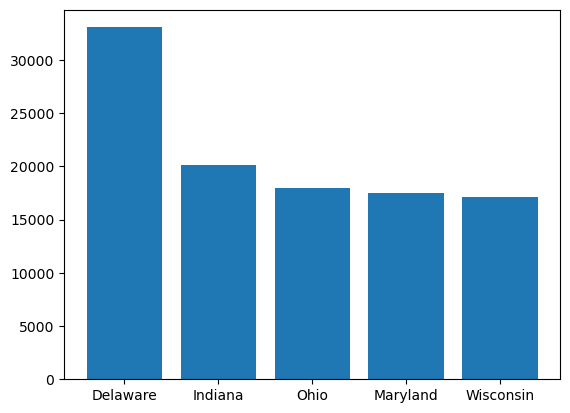

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plotted_5 = State_area.head()

plt.bar(plotted_5['STATE'], plotted_5['Weighted_Expectation'])
plt.show

Next I will create a seperate dataframe for state level data. This project will begin by searching at the state level to identify interesting trends, because it is difficult to properly visualize 3000+ counties.

    At this point I have:
- 1)the dictionary of data that I began with, uncleaned - data
- 2) The dictionary of cleaned data - nri_county
- 3) The merged cleaned county data - county_clean

    Next:
    
- 4) will be the dictionary of cleaned, averaged state data - nri_state_score
- 5) I will also create a dictionary of cleaned, summed state data - nri_state_freq

    Last:
    
- 6) I will create the merged cleaned state data - state_clean